In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install silence_tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.3-py3-none-any.whl size=6749 sha256=0005b8f16ffd892ddae8baebada7df27ba4fc5eb59ae6a98202136cc2abac0ec
  Stored in directory: /root/.cache/pip/wheels/2e/91/a1/2d32c0ea21439c6367fe1acaa2d3a0377a95ae51cf47c13521
Successfully built silence_tensorflow


In [ ]:
# A function to avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# **IMPORT LIBRARY**

In [ ]:
import os
import cv2
import random
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copy2
from PIL import Image
from termcolor import colored
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(tf.__version__)

2.17.1


In [ ]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# **PREPROCESSING DATA**

- resize 224x224

In [ ]:
def resize_image(input_path, output_path, size=(224, 224)):
    """Resize image to the specified size and save it to the output path."""
    with Image.open(input_path) as img:
        # Konversi gambar ke mode RGB jika gambar berada dalam mode RGBA atau mode lainnya
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(size, Image.LANCZOS)
        img.save(output_path)

def process_directory(input_dir, output_dir, size=(224, 224)):
    """Process all images in the input directory and save them to the output directory."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                input_file_path = os.path.join(root, file)
                output_file_path = os.path.join(output_dir, os.path.relpath(input_file_path, input_dir))

                # Create the output directory if it does not exist
                output_file_dir = os.path.dirname(output_file_path)
                if not os.path.exists(output_file_dir):
                    os.makedirs(output_file_dir)

                # Resize and save the image
                resize_image(input_file_path, output_file_path, size)

In [23]:
 input_base_dir = '/content/drive/MyDrive/ship_classification1'
 output_base_dir = '/content/drive/MyDrive/224x224data'

 process_directory(input_base_dir, output_base_dir, size=(224, 224))

 print("Image resizing completed!")

Image resizing completed!


- Split data

In [24]:
dir_data_224 = '/content/drive/MyDrive/224x224data'
dir_tvt = '/content/drive/MyDrive/ship_classification1'

In [25]:
deases_class = [dir for dir in os.listdir(dir_data_224) if os.path.isdir(os.path.join(dir_data_224, dir))]
print(deases_class)

['Aircraft Carrier', 'Barge', 'Auxiliary Ship', 'Cargo', 'Container Ship', 'Destroyer', 'Cruiser', 'Commander', 'Oil Tanker', 'Ferry', 'Dock', 'Fishing Vessel', 'Frigate', 'Motorboat', 'Landing', 'Hovercraft', 'Other Ship', 'Other Merchant', 'Other Warship', 'Submarine', 'Sailboat', 'Patrol', 'RoRo', 'Yacht', 'Tugboat']


In [26]:

 for desases in deases_class:
     print(desases)
     deases_path = os.path.join(dir_data_224, desases) #\data224x224\Coccidiosis
     all_image_paths = []

     if os.path.exists(deases_path):
         paths = [os.path.join(deases_path, f) for f in os.listdir(deases_path) if os.path.isfile(os.path.join(deases_path, f))]
         all_image_paths.extend(paths)

     random.shuffle(all_image_paths)

     # Split images into train, validation, and test sets
     num_images = len(all_image_paths)
     train_size = int(0.8 * num_images)
     valid_size = int(0.1 * num_images)
     test_size = num_images - train_size - valid_size

     train_paths = all_image_paths[:train_size]
     valid_paths = all_image_paths[train_size:train_size + valid_size]
     test_paths = all_image_paths[train_size + valid_size:]

     # Copy images
     for path in train_paths:
         dst_dir = os.path.join(dir_tvt, 'train', desases)
         if not os.path.exists(dst_dir):
             os.makedirs(dst_dir)
         copy2(path, os.path.join(dst_dir, os.path.basename(path)))

     for path in valid_paths:
         dst_dir = os.path.join(dir_tvt, 'validation', desases)
         if not os.path.exists(dst_dir):
             os.makedirs(dst_dir)
         copy2(path, os.path.join(dst_dir, os.path.basename(path)))

     for path in test_paths:
         dst_dir = os.path.join(dir_tvt, 'test', desases)
         if not os.path.exists(dst_dir):
             os.makedirs(dst_dir)
         copy2(path, os.path.join(dst_dir, os.path.basename(path)))


Aircraft Carrier
Barge
Auxiliary Ship
Cargo
Container Ship
Destroyer
Cruiser
Commander
Oil Tanker
Ferry
Dock
Fishing Vessel
Frigate
Motorboat
Landing
Hovercraft
Other Ship
Other Merchant
Other Warship
Submarine
Sailboat
Patrol
RoRo
Yacht
Tugboat


# **IMPORT DATA**

In [27]:
train_dir = os.path.join(dir_tvt, 'train')
validation_dir = os.path.join(dir_tvt, 'validation')
test_dir = os.path.join(dir_tvt, 'test')

# **Count data and classes**

In [12]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [28]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 25
number of classes in validation folder : 25
number of classes in test folder : 25


In [29]:
def plot_num_of_samples(path, labeling) :
  classes = [class_name for class_name in os.listdir(path)]
  count = []
  for class_name in classes :
      count.append(len(os.listdir(os.path.join(path, class_name))))

  plt.figure(figsize=(15, 4))
  ax = sns.barplot(x=classes, y=count, color='Green')
  # plt.xticks(rotation=285)
  for i in ax.containers:
      ax.bar_label(i,)
  plt.title(labeling, fontsize=25, fontweight='bold')
  plt.xlabel('Labels', fontsize=15)
  plt.ylabel('Counts', fontsize=15)
  plt.yticks(np.arange(0, 1500, 100))
  plt.show()

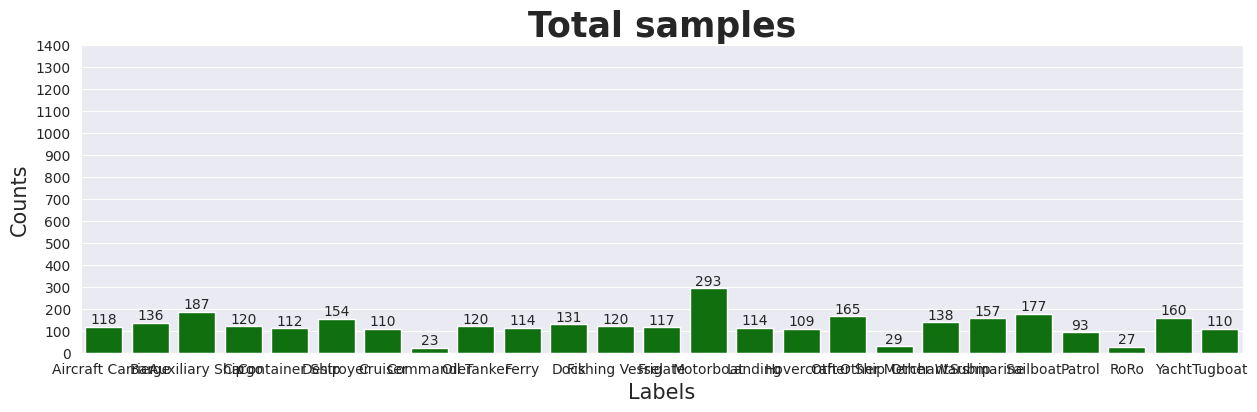

In [30]:
plot_num_of_samples(dir_data_224, 'Total samples')

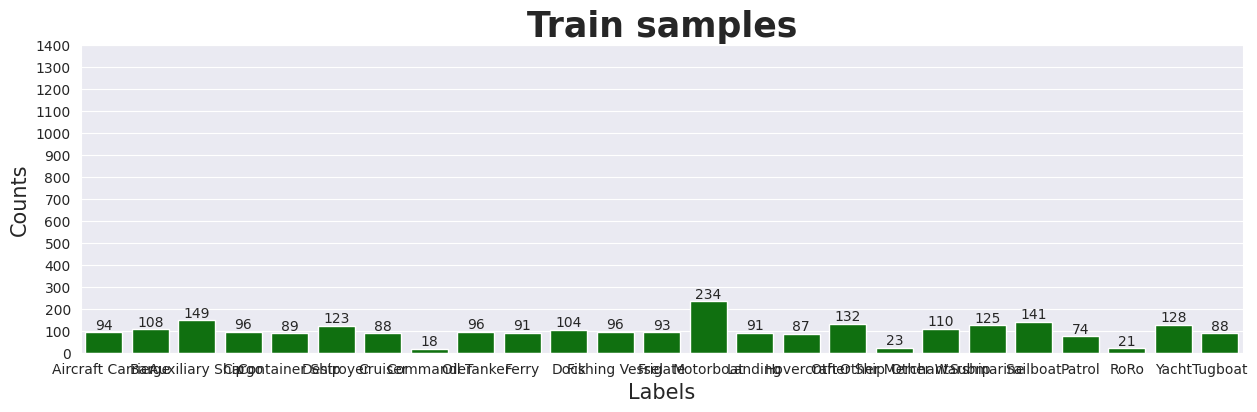

In [31]:
plot_num_of_samples(train_dir, 'Train samples')

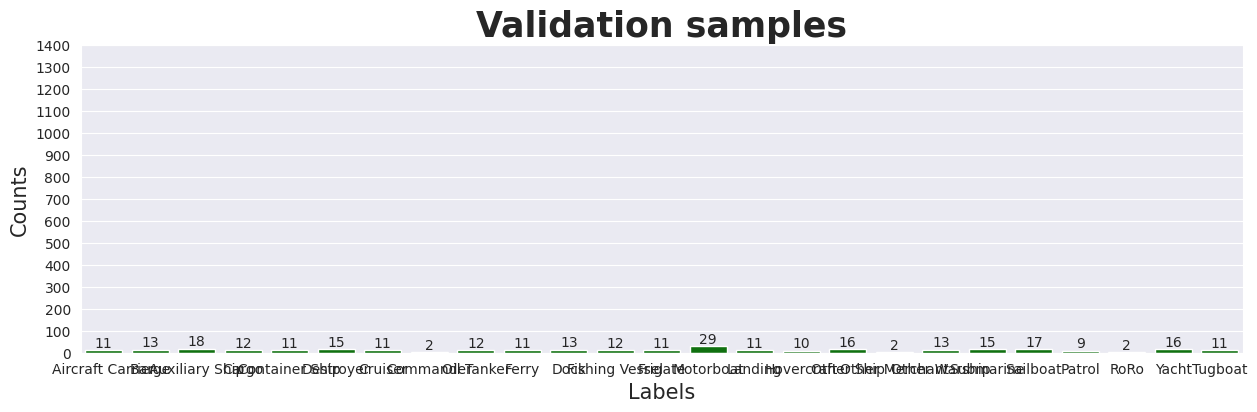

In [32]:
plot_num_of_samples(validation_dir, 'Validation samples')

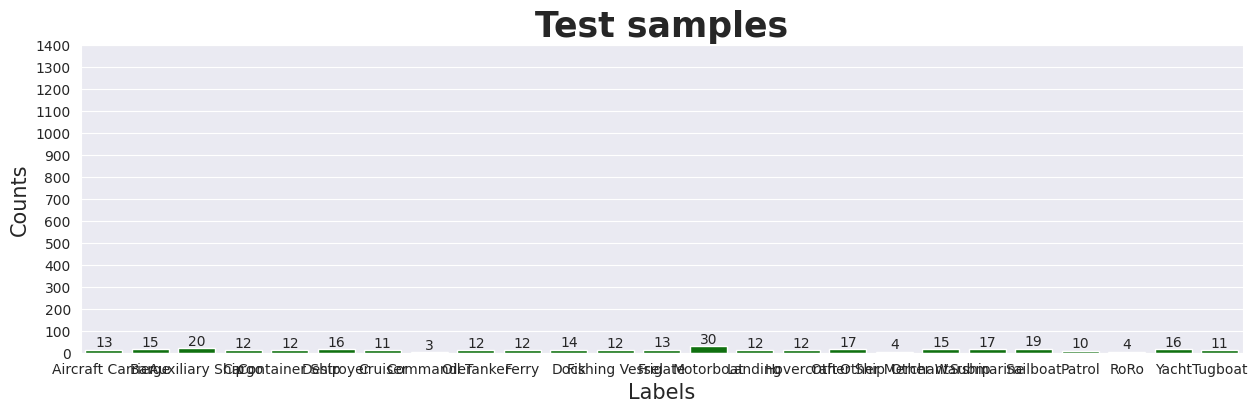

In [33]:
plot_num_of_samples(test_dir, 'Test samples')

# **Convert data to a DataFrame**

In [34]:
# A function to return DataFrame
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [35]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [36]:
print(colored(f'Total Sample : {len(train_df) + len(validation_df) + len(test_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Total Sample : 3134
Number of samples in train : 2499
Number of samples in validation : 303
Number of samples test : 332


# **visualisasi image**

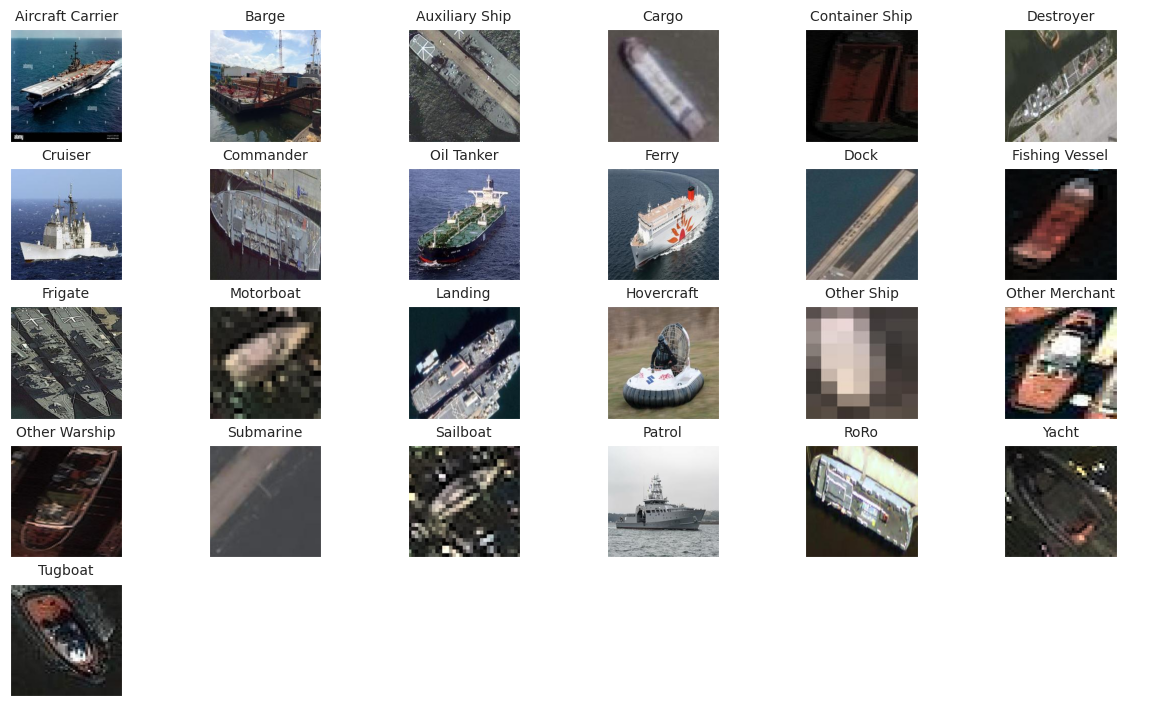

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df is already defined
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Number of unique labels
num_unique_labels = df_unique.shape[0]

# Calculate the number of rows and columns needed for subplots
nrows = (num_unique_labels // 6) + 1
ncols = min(num_unique_labels, 6)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes[:num_unique_labels]):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize=10)

# Hide any remaining subplots if there are any
for ax in axes[num_unique_labels:]:
    ax.axis('off')

plt.tight_layout(pad=0.5)
plt.show()


# **Data generators**

In [104]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    vertical_flip=True,              # Allow vertical flipping
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,
    # Explicitly specify the number of classes
    # to match your model's output layer
    num_classes=25  # This should match the number of classes in your dataset
)

Found 2499 validated image filenames belonging to 25 classes.


In [112]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,

    num_classes=25
)

Found 303 validated image filenames belonging to 25 classes.


In [113]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=24,

    num_classes=25
)

Found 332 validated image filenames belonging to 25 classes.


# **Build MobileNetV2 model**

In [93]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    classifier_activation='softmax',      # activation function
    pooling='avg'                         # type of pooling layer
)

# **Freeze MobileNetV2 layers**

In [94]:
# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    print(layer.name)


input_layer_8
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_

In [114]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

# **Mendefinisikan model**

In [117]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(25, activation='softmax'))


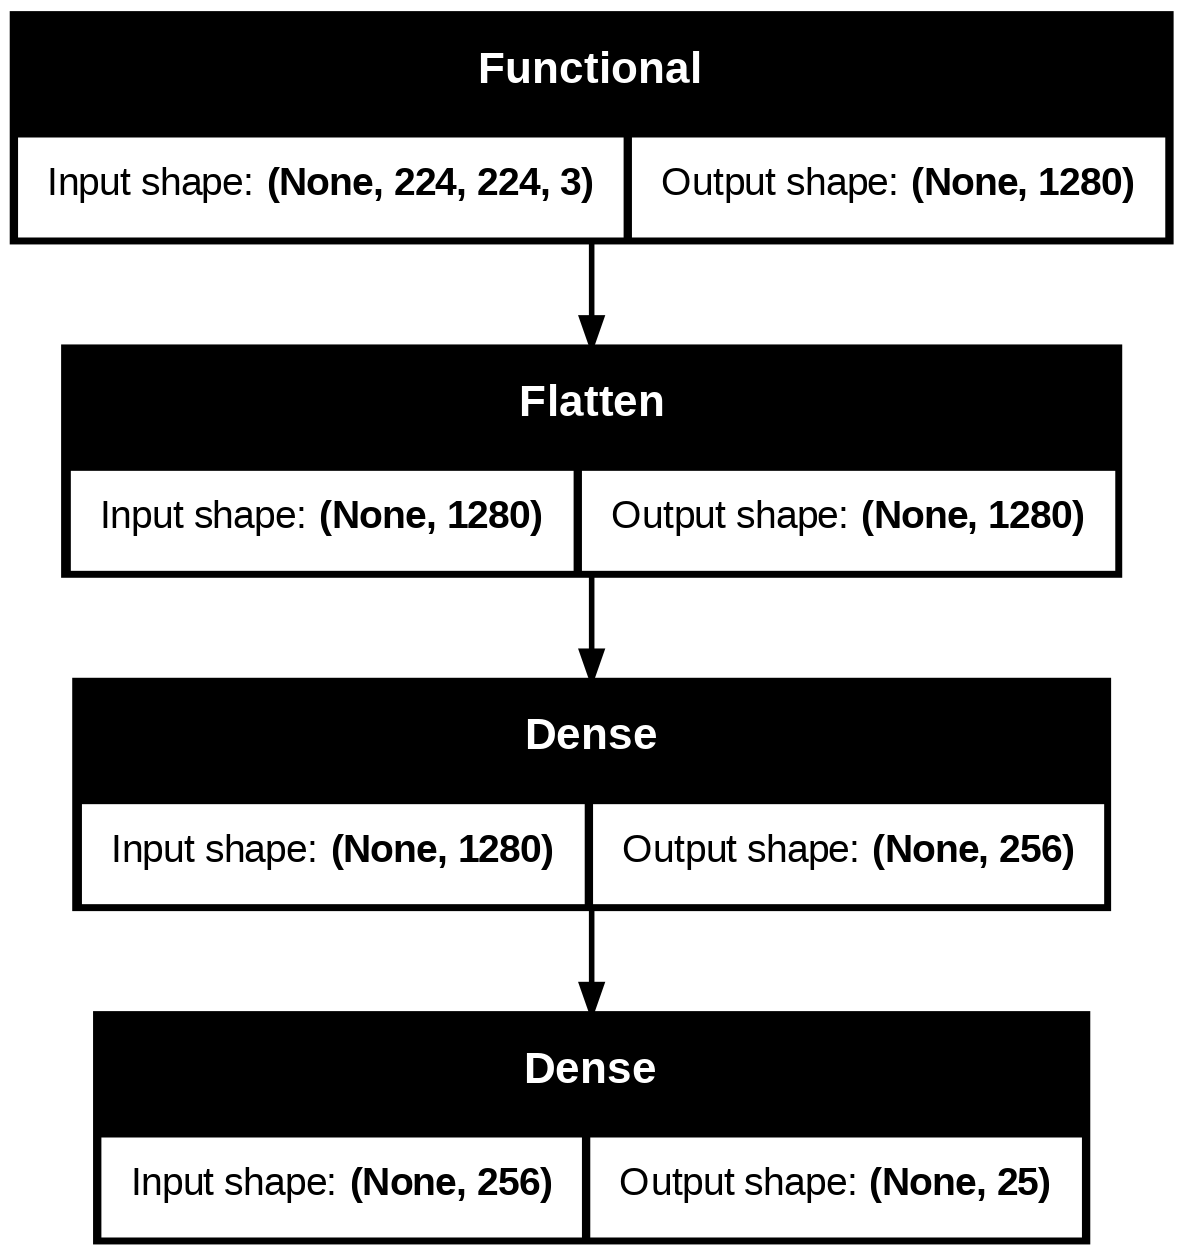

In [118]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [119]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 25)                  │           6,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,592,345 (9.89 MB)

 Trainable params: 1,220,441 (4.66 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

# **Compile Model**

In [120]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [121]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint(
    'my_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Early Stoping
earlystop_cb = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_loss',
    mode='min'
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='min'
)

# **Train Model**

In [123]:
history = model.fit(
    train_generator,
    epochs= 20,
    batch_size=32,
    verbose= 1,
    callbacks= [checkpoint_cb, earlystop_cb, reduce_lr],
    validation_data= validation_generator,
    validation_steps= None,
    shuffle= False
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5286 - loss: 1.5704
Epoch 1: val_loss improved from 2.61969 to 2.19379, saving model to my_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.5286 - loss: 1.5704 - val_accuracy: 0.3564 - val_loss: 2.1938 - learning_rate: 1.0000e-04
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5735 - loss: 1.3984
Epoch 2: val_loss improved from 2.19379 to 2.16339, saving model to my_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.5735 - loss: 1.3982 - val_accuracy: 0.3663 - val_loss: 2.1634 - learning_rate: 1.0000e-04
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6304 - loss: 1.2100
Epoch 3: val_loss improved from 2.16339 to 2.03035, saving model to my_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6303 - loss: 1.2099 - val_accuracy: 0.4191 - val_loss: 2.0303 - learning_rate: 1.0000e-04
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6535 - 

# **Plot the result of training**

In [124]:
# Convert result of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

accuracy      loss  val_accuracy  val_loss  learning_rate
15  0.831933  0.543299      0.574257  1.437959       0.000012
16  0.830332  0.549662      0.587459  1.427062       0.000012
17  0.840336  0.528718      0.594059  1.406927       0.000012
18  0.845538  0.512186      0.597360  1.387451       0.000012
19  0.851140  0.511177      0.590759  1.389159       0.000012

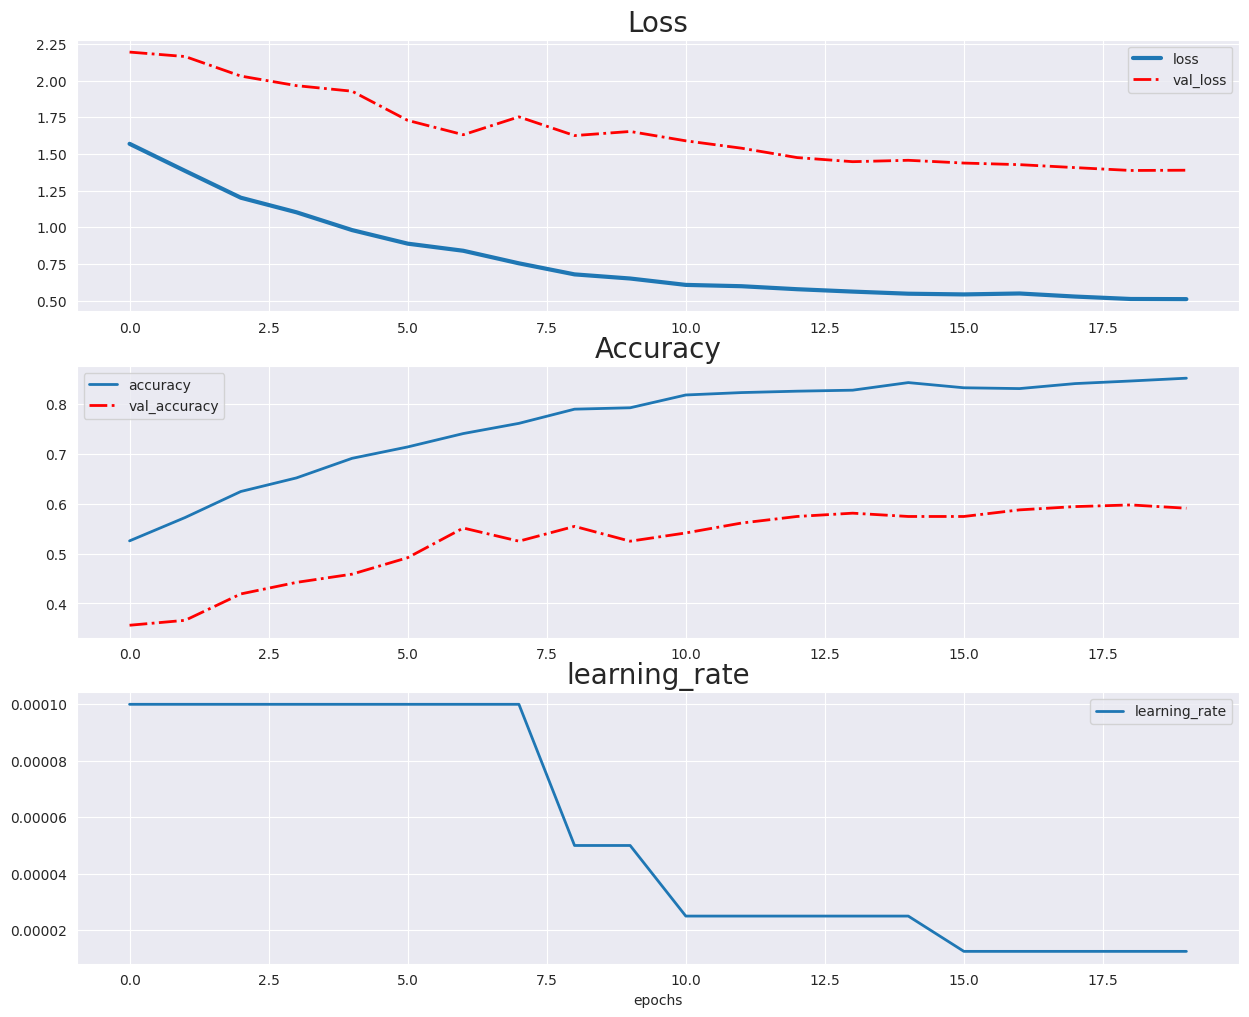

In [125]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

# **MODEL PREDICTION TEST DATASET**

In [126]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Aircraft Carrier
1 : Auxiliary Ship
2 : Barge
3 : Cargo
4 : Commander
5 : Container Ship
6 : Cruiser
7 : Destroyer
8 : Dock
9 : Ferry
10 : Fishing Vessel
11 : Frigate
12 : Hovercraft
13 : Landing
14 : Motorboat
15 : Oil Tanker
16 : Other Merchant
17 : Other Ship
18 : Other Warship
19 : Patrol
20 : RoRo
21 : Sailboat
22 : Submarine
23 : Tugboat
24 : Yacht


In [127]:
predictions = model.predict(test_generator)

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


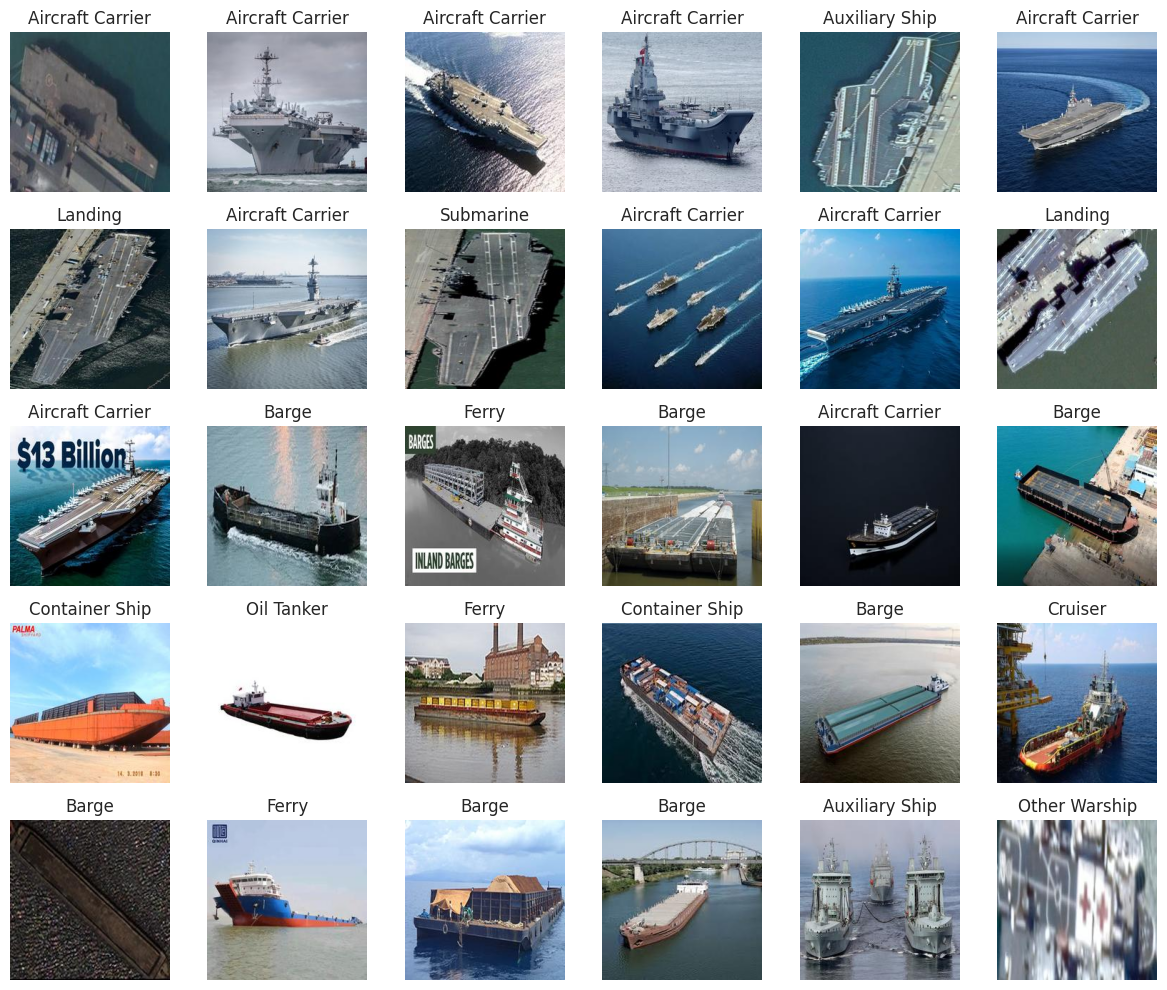

In [128]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(12, 10))
idx = 0

for i in range(5):
    for j in range(6):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
# plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [129]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5802 - loss: 1.3101


In [130]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy} -> {test_accuracy*100:.2f}%")

Test Loss:     1.2688425779342651
Test Accuracy: 0.5873494148254395 -> 58.73%


# **PLOT CONFUSION MATRIX**

In [131]:
y_hat = np.argmax(predictions, axis=1)
y_true = test_generator.classes

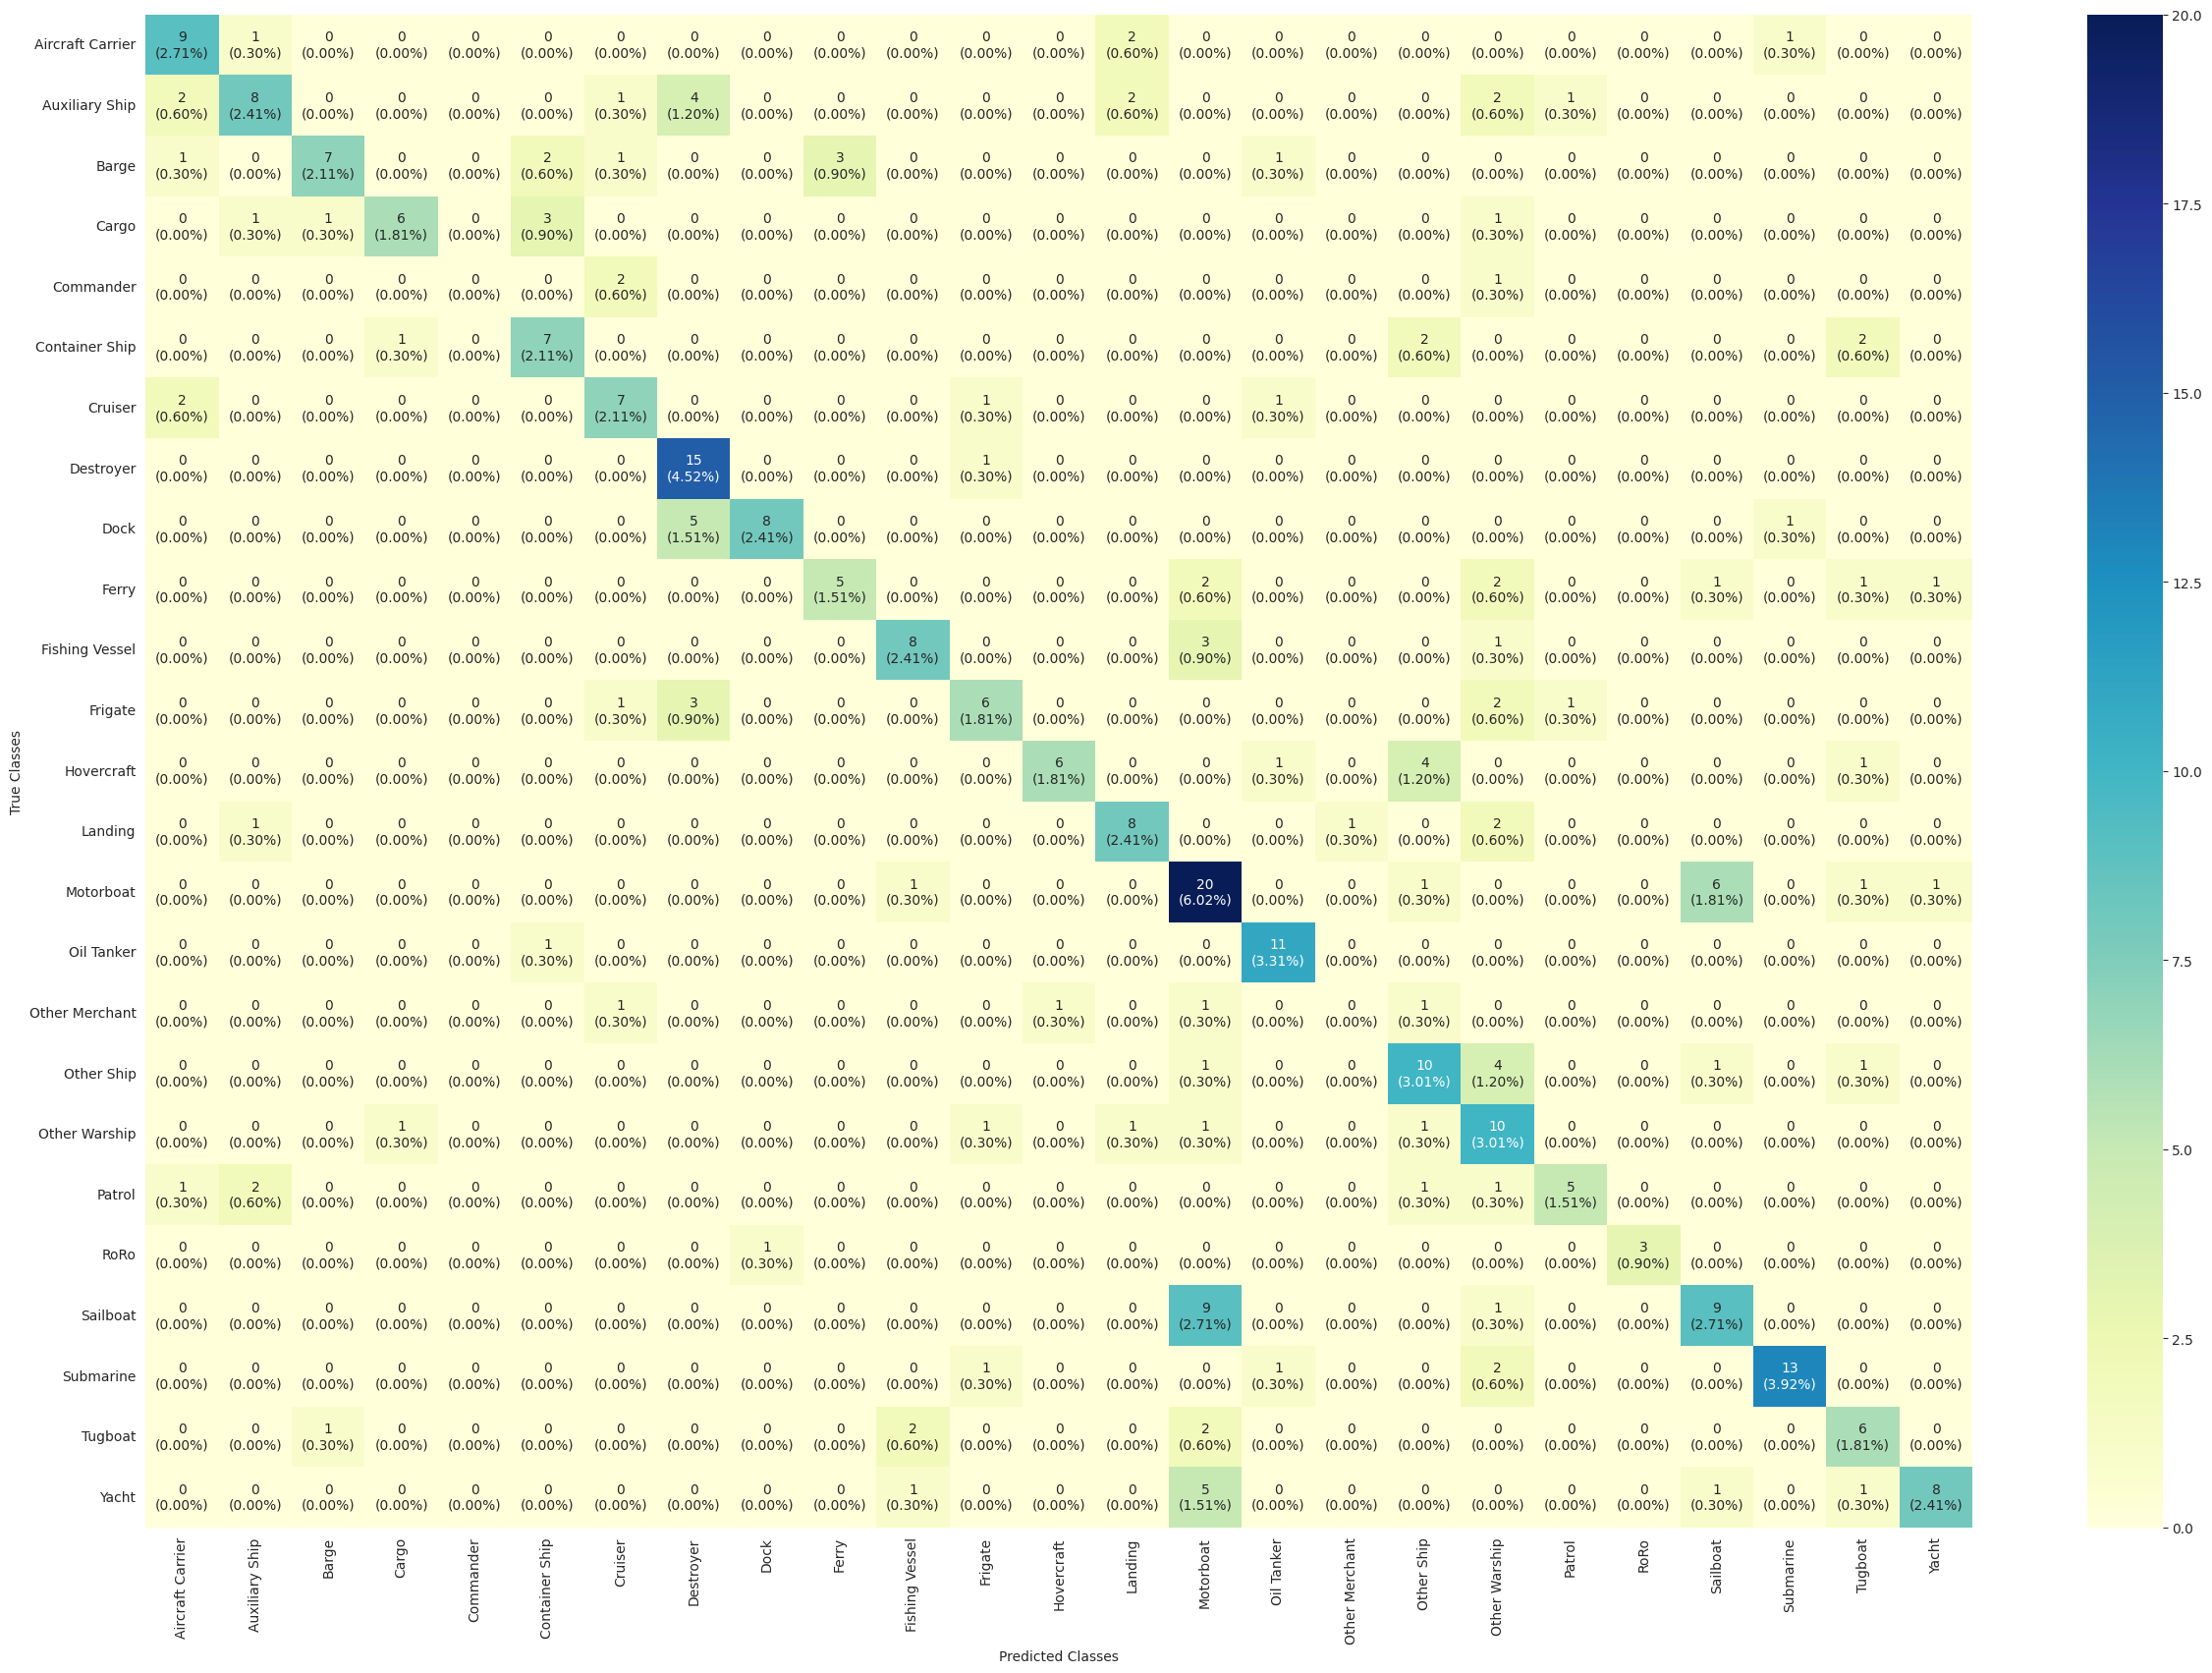

In [134]:
cf_mtx = confusion_matrix(y_true, y_hat)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
# Reshape to the correct dimensions (25x25)
box_labels = np.asarray(box_labels).reshape(cf_mtx.shape[0], cf_mtx.shape[1])

plt.figure(figsize = (30, 20))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [135]:
print(classification_report(y_true, y_hat, target_names=labels.values()))

                  precision    recall  f1-score   support

Aircraft Carrier       0.60      0.69      0.64        13
  Auxiliary Ship       0.62      0.40      0.48        20
           Barge       0.78      0.47      0.58        15
           Cargo       0.75      0.50      0.60        12
       Commander       0.00      0.00      0.00         3
  Container Ship       0.54      0.58      0.56        12
         Cruiser       0.54      0.64      0.58        11
       Destroyer       0.56      0.94      0.70        16
            Dock       0.89      0.57      0.70        14
           Ferry       0.62      0.42      0.50        12
  Fishing Vessel       0.67      0.67      0.67        12
         Frigate       0.60      0.46      0.52        13
      Hovercraft       0.86      0.50      0.63        12
         Landing       0.62      0.67      0.64        12
       Motorboat       0.45      0.67      0.54        30
      Oil Tanker       0.73      0.92      0.81        12
  Other Merch

# **WRONG PREDICT**

In [136]:
y_true = np.array(y_true)
print(y_true.shape)

(332,)


In [137]:
errors = (y_true - y_hat != 0)
error_indices = np.where(errors)[0]
y_true_errors = y_true[error_indices]
y_hat_errors = y_hat[error_indices]


In [138]:
# Menghitung jumlah total prediksi
total_predictions = y_true.shape[0]

# Menghitung jumlah prediksi yang salah
total_errors = y_true_errors.shape[0]

# Menghitung persentase prediksi yang salah
error_percentage = (total_errors / total_predictions) * 100

print(f"Jumlah total prediksi: {total_predictions}")
print(f"Jumlah prediksi yang salah: {total_errors}")
print(f"Persentase prediksi yang salah: {error_percentage}%")

Jumlah total prediksi: 332
Jumlah prediksi yang salah: 137
Persentase prediksi yang salah: 41.265060240963855%


In [139]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

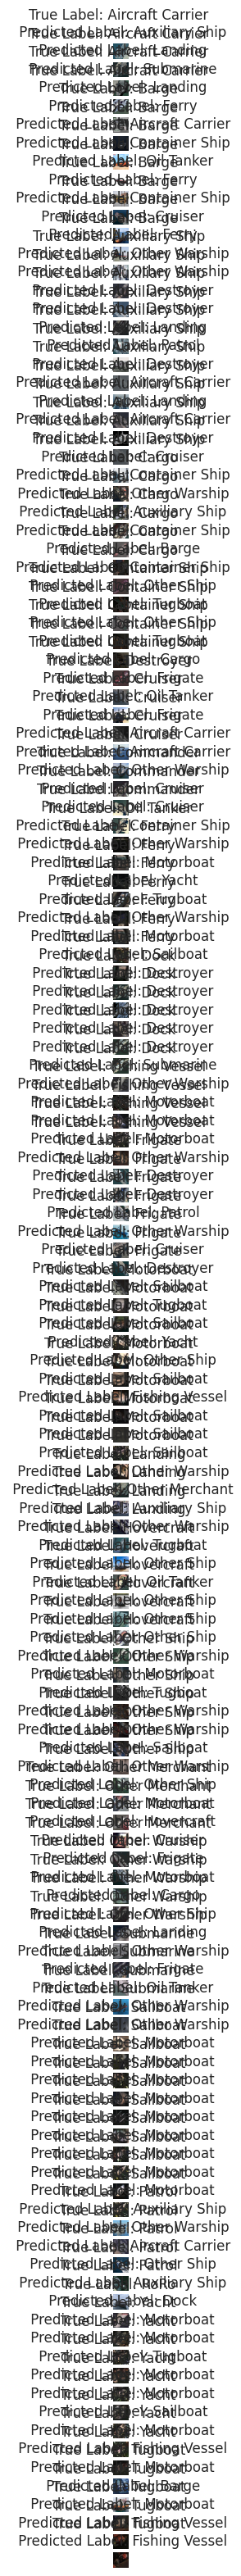

In [140]:
fig, ax = plt.subplots(nrows=total_errors, ncols=1, figsize=(50, 40))

for idx, error in enumerate(y_true_errors):
    true_label = labels[error]
    predicted_label = labels[y_hat_errors[idx]]
    ax[idx].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
    img_path = os.path.join(test_dir, test_img[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[idx].imshow(img)
    ax[idx].axis("off")

plt.tight_layout()
# plt.suptitle('All Wrong Predictions made on test set', fontsize=20)
plt.show()


In [141]:
model.save('/content/drive/MyDrive/Colab Notebooks/UAP/model_MNV2.h5')